In [1]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import logging
logging.basicConfig(
format="%(levelname)s %(funcName)s():%(lineno)i: %(message)s",
)

# Readout segmentation

In [2]:
import numpy as np
import random as rand
from scipy import spatial

# geometry parameters
n_coded_chans = 99
height = 100
width = 100
# pad segmentation for coded readout
k = 50
l = 50
# pad segmentation for pixelated readout on opposing plane
m = 9
n = 9

# build arrays mapping coded readout pads to channel numbers
coded_pitch_y = height / k
coded_pitch_x = width / l

chans = [i for i in range(0, n_coded_chans)]

coded_pad_x = []
coded_pad_y = []
coded_pad_c = []

for i in range(0, k):
    for j in range(0, l):
        coded_pad_y.append(height/2 - (i+0.5)*coded_pitch_y)
        coded_pad_x.append(width/2 - (j+0.5)*coded_pitch_x)

        """
        coded readout selects channels at random
        for each pad from a small pool
        """ 
        coded_pad_c.append(rand.choice(chans))

coded_pad_x = np.array(coded_pad_x)
coded_pad_y = np.array(coded_pad_y)
coded_pad_c = np.array(coded_pad_c)

# build arrays mapping pixelated pads to channel numbers
pixel_pitch_y = height / m
pixel_pitch_x = width / n

pixel_pad_x = []
pixel_pad_y = []
pixel_pad_c = []

for i in range(0, m):
    for j in range(0, n):
        pixel_pad_y.append(height/2 - (i+0.5)*pixel_pitch_y)
        pixel_pad_x.append(width/2 - (j+0.5)*pixel_pitch_x)

        """
        each pad for the pixelated readout gets
        a unique channel
        """ 
        pixel_pad_c.append(n_coded_chans + i*n + j)

pixel_pad_x = np.array(pixel_pad_x)
pixel_pad_y = np.array(pixel_pad_y)
pixel_pad_c = np.array(pixel_pad_c)

# define nearest channel sample binning using native KDTree search
coded_pad_tree = spatial.cKDTree(np.transpose([coded_pad_x, coded_pad_y]))
pixel_pad_tree = spatial.cKDTree(np.transpose([pixel_pad_x, pixel_pad_y]))
def chan_counts(xy, split=True, randomize=True):
    if randomize:
        np.random.shuffle(xy)

    # split the samples evenly between the coded and pixelated planes
    if split:
        xy1 = xy[:len(xy)//2]
        xy2 = xy[len(xy)//2:]
    else:
        xy1 = xy
        xy2 = xy

    # bin the samples by channel
    _, coded_pads = coded_pad_tree.query(xy1)
    coded_pads, coded_counts = np.unique(coded_pads, return_counts=True)
    _, pixel_pads = pixel_pad_tree.query(xy2)
    pixel_pads, pixel_counts = np.unique(pixel_pads, return_counts=True)
    try:
        coded_pads, counts = zip(
            *filter(
                lambda x: x[0] < len(coded_pad_c),
                zip(coded_pads, coded_counts),
            ),
        )
        pixel_pads, counts = zip(
            *filter(
                lambda x: x[0] < len(pixel_pad_c),
                zip(pixel_pads, pixel_counts),
            ),
        )
        return zip(
            np.concatenate(
                [coded_pad_c[list(coded_pads)],
                 pixel_pad_c[list(pixel_pads)]],
            ),
            np.concatenate([coded_counts, pixel_counts]),
        )
    except ValueError:
        return []

# Tomography

In [3]:
import logging
import nngpt

logging.getLogger().setLevel(logging.INFO)

# initialize planar nonnegative gaussian process tomography
p = nngpt.Planar(
    n_coded_chans + m*n,
    chan_counts,
    m=k, n=l,
    sample_density=1000,
)

INFO _init_design():171: g integration time: 11.119
INFO _init_design():216: covariance matrix calculation time: 1.483
INFO _init_tomo():274: setup time: 0.108


In [4]:
import logging
import nngpt
import matplotlib.pyplot as plt

def plot_tomo_for_samples(xy):
    logging.getLogger().setLevel(logging.INFO)

    xy_diff = nngpt.add_diffusion(xy, p.max_diff_sigma)
    q = p.bin_channels(xy_diff)
    img = p.tomo(q)
    mean, cov = p.get_mean_and_cov(img)
    true_img = p.bin_pixels(xy)
    true_mean, true_cov = p.get_mean_and_cov(true_img)

    print('Simulated channel input')
    plt.plot(q)
    plt.show()

    print(
        'True image (left) vs reconstructed image (right)',
        'with calculated 3-sigma confidence ellipses'
    )
    nngpt.draw_tomo(
        [true_img, img], p.width, p.height, colorbar=True,
        mean=[None,[mean]], cov=[None,[cov]],
        true_mean=[[true_mean],None], true_cov=[[true_cov],None],
    )
    plt.show()
    
    print('Differences in the images and overlayed confidence ellipses')
    nngpt.draw_tomo(
        img-true_img, p.width, p.height, colorbar=True,
        true_mean=[[true_mean]], true_cov=[[true_cov]],
        mean=[[mean]], cov=[[cov]],
    )
    plt.show()

## Covariant Gaussian

INFO sample_normal():16: sampling time: 0.134
INFO add_diffusion():67: sampling time: 0.163
INFO bin_channels():97: binning time: 1.741
INFO tomo():79: tomography time: 0.101
INFO tomo():80: tomography iterations: 5
INFO tomo():81: unconstrained pixel count: 44
INFO bin_pixels():110: binning time: 0.578


Simulated channel input


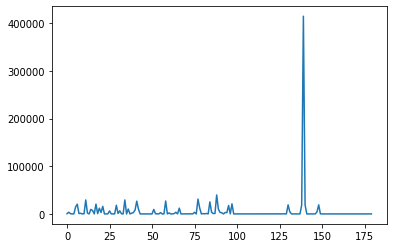

True image (left) vs reconstructed image (right) with calculated 3-sigma confidence ellipses


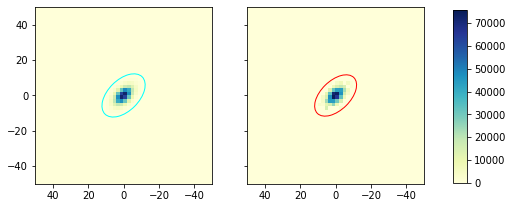

Differences in the images and overlayed confidence ellipses


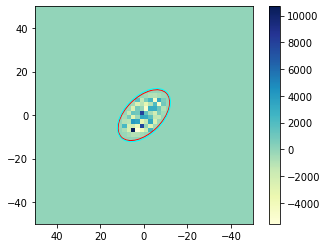

In [5]:
import nngpt
import numpy as np

means = np.array([[0,0]])
covs = 9*np.array([[[1,-0.5],[-0.5,1]]])
n_samples = [1e6]

xy = nngpt.sample_normal(means, covs, n_samples)
plot_tomo_for_samples(xy)

## Two Gaussians

INFO sample_normal():16: sampling time: 0.231
INFO add_diffusion():67: sampling time: 0.291
INFO bin_channels():97: binning time: 3.343
INFO tomo():79: tomography time: 0.030
INFO tomo():80: tomography iterations: 6
INFO tomo():81: unconstrained pixel count: 46
INFO bin_pixels():110: binning time: 1.079


Simulated channel input


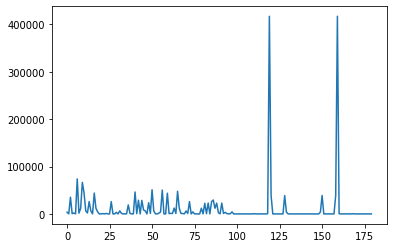

True image (left) vs reconstructed image (right) with calculated 3-sigma confidence ellipses


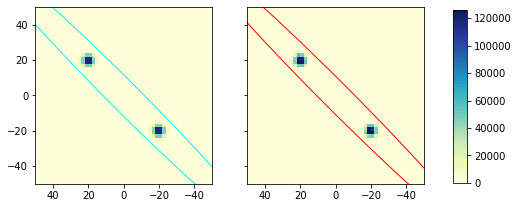

Differences in the images and overlayed confidence ellipses


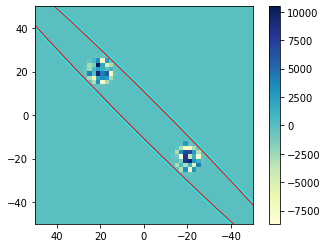

In [6]:
import nngpt
import numpy as np

means = 20*np.array([[1,1],[-1,-1]])
covs = 4*np.array([[[1,0],[0,1]],[[1,0],[0,1]]])
n_samples = [1e6,1e6]

xy = nngpt.sample_normal(means, covs, n_samples)
plot_tomo_for_samples(xy)

## Small circle convolved with Gaussian

INFO sample_circle():33: sampling time: 2.022
INFO add_diffusion():67: sampling time: 1.637
INFO bin_channels():97: binning time: 17.207
INFO tomo():79: tomography time: 0.025
INFO tomo():80: tomography iterations: 7
INFO tomo():81: unconstrained pixel count: 103
INFO bin_pixels():110: binning time: 6.140


Simulated channel input


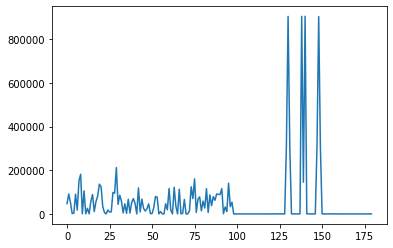

True image (left) vs reconstructed image (right) with calculated 3-sigma confidence ellipses


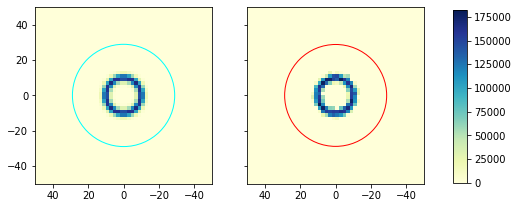

Differences in the images and overlayed confidence ellipses


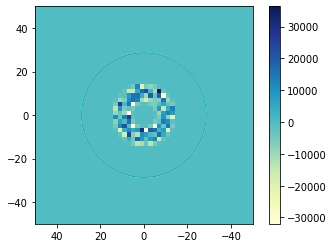

In [7]:
import nngpt

xy = nngpt.sample_circle(r=10)
plot_tomo_for_samples(xy)

## Large circle convolved with Gaussian

INFO sample_circle():33: sampling time: 2.032
INFO add_diffusion():67: sampling time: 1.587
INFO bin_channels():97: binning time: 18.006
INFO tomo():79: tomography time: 0.031
INFO tomo():80: tomography iterations: 10
INFO tomo():81: unconstrained pixel count: 217
INFO bin_pixels():110: binning time: 6.468


Simulated channel input


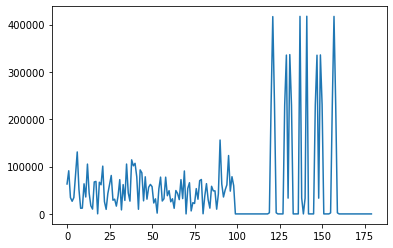

True image (left) vs reconstructed image (right) with calculated 3-sigma confidence ellipses


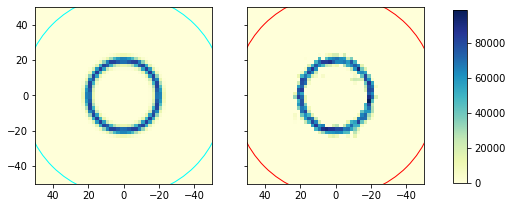

Differences in the images and overlayed confidence ellipses


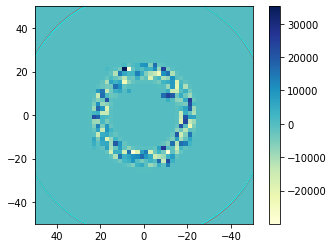

In [8]:
import nngpt

xy = nngpt.sample_circle(r=20)
plot_tomo_for_samples(xy)

## Execution time benchmark using covariant Gaussian

In [9]:
import logging
import nngpt

logging.getLogger().setLevel(logging.ERROR)

means = np.array([[0,0]])
covs = 9*np.array([[[1,-0.5],[-0.5,1]]])
n_samples = [1e6]

xy = nngpt.sample_normal(means, covs, n_samples)
xy_diff = nngpt.add_diffusion(xy, p.max_diff_sigma)
q = p.bin_channels(xy_diff)

%timeit p.tomo(q, ret_pixels=False)

100 loops, best of 5: 14 ms per loop
